## 🔧 **Importación de librerías**

In [11]:
!pip install opencv-python


Defaulting to user installation because normal site-packages is not writeable


In [13]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature.texture import graycomatrix, graycoprops
import matplotlib.pyplot as plt
import os
import cv2
import numpy as np
import random





## 📥 **Variables de entorno**

In [ ]:

carpeta_preprocesadas = '../data/preprocesadas/'
train_normal =carpeta_preprocesadas+'train/NORMAL/'
train_pneumonia =carpeta_preprocesadas+'train/PNEUMONIA/'
test_normal =carpeta_preprocesadas+'test/NORMAL/'
test_pneumonia =carpeta_preprocesadas+'test/PNEUMONIA/'
val_normal =carpeta_preprocesadas+'val/NORMAL/'
val_pneumonia =carpeta_preprocesadas+'val/PNEUMONIA/'
dir_train =carpeta_preprocesadas+'train/'
dir_test =carpeta_preprocesadas+'test/'
dir_val =carpeta_preprocesadas+'val/'
salida_caracteristicas = 'data/caracteristicas/'

## 📥 **Cargar imagenes y visualizar**

Seleccionamos 3 imágenes al azar de cada categoría 

In [16]:
#display 2x3 con 3 imagenes al azar de nuemonia y 3 de normal del set de train

# Seleccionar 3 imágenes al azar de cada categoría  
normal_images = os.listdir(train_normal)
neumonia_images = os.listdir(train_pneumonia)
random_normal_images = random.sample(normal_images, 3)
random_neumonia_images = random.sample(neumonia_images, 3)

cell_size = (8, 8)
block_size = (16, 16)
block_stride = (8, 8)
num_bins = 9




## ✨ **1. Momentos de Hu**
Los Momentos de Hu son 7 valores derivados de momentos invariantes de la imagen, los cuales son:
- Invariantes a **traslación**
- Invariantes a **rotación**
- Invariantes a **escala**

El séptimo momento también es sensible a reflexiones.


In [22]:
def extraer_momentos_hu(img_gray):
    # Asegurar que sea uint8
    img_gray = img_gray.astype("uint8")

    # 1) Suavizado
    blur = cv2.GaussianBlur(img_gray, (5,5), 0)

    # 2) Binarización Otsu
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # 3) Momentos
    M = cv2.moments(thresh)
    hu = cv2.HuMoments(M).flatten()

    # 4) Log-transform
    hu_log = [-np.sign(h) * np.log10(abs(h)) if h != 0 else 0 for h in hu]

    return hu_log, thresh



### 🔍 **Visualización del contorno utilizado en los momentos**

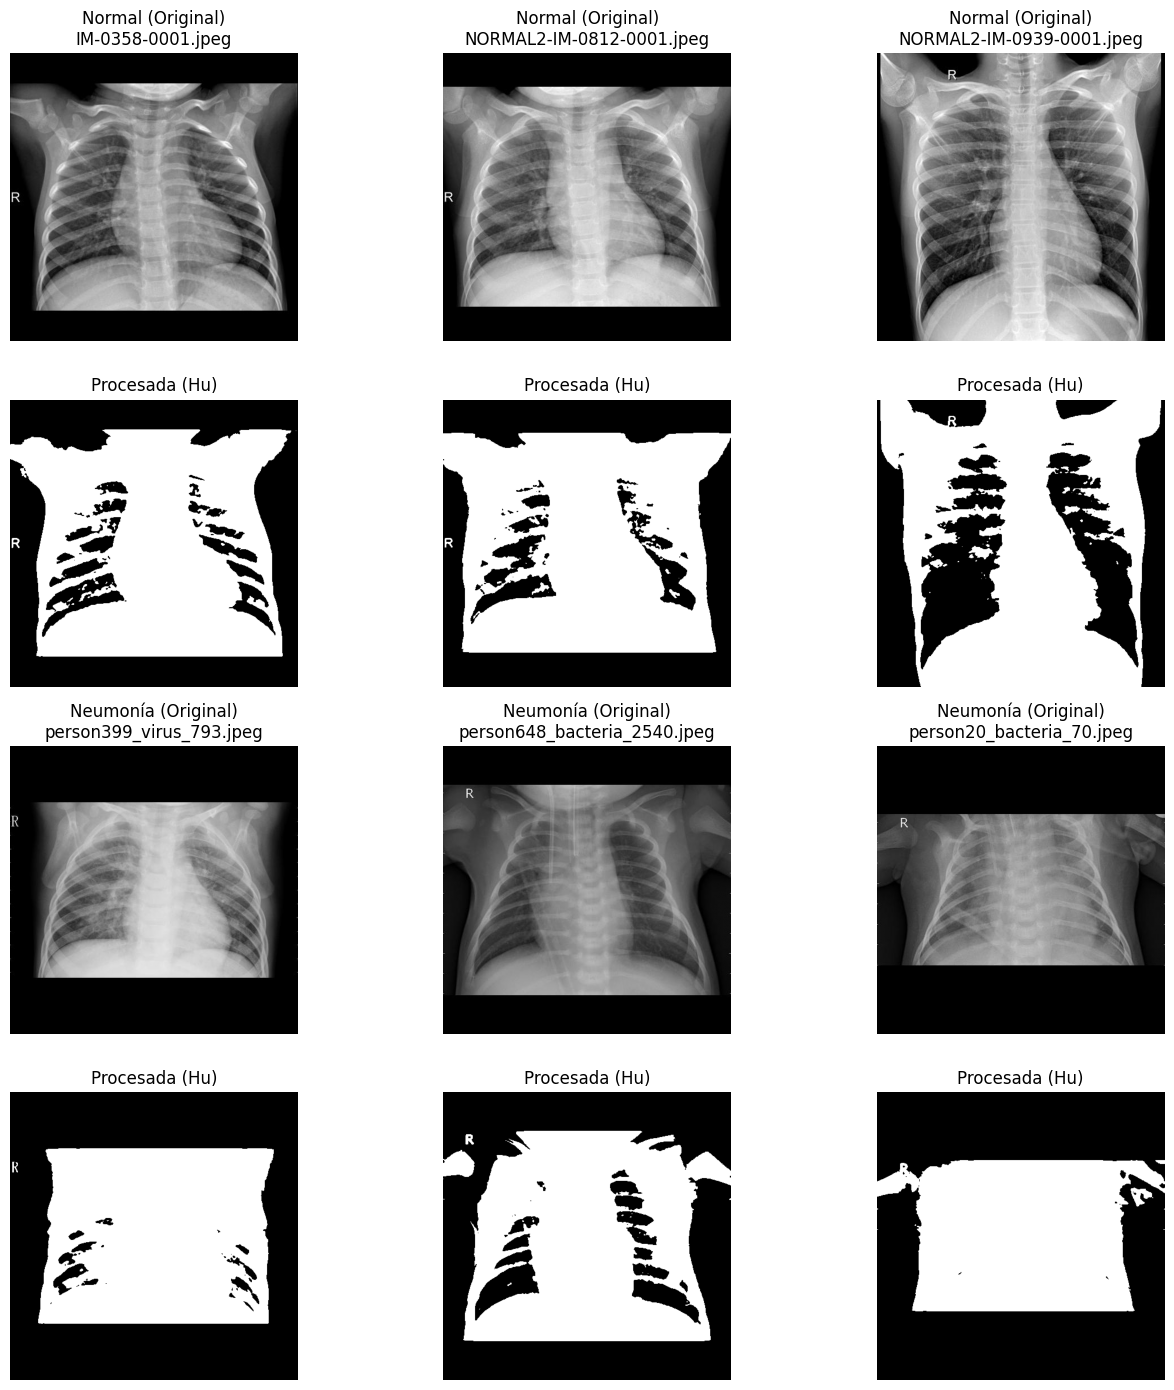

In [26]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2

def extraer_momentos_hu(img_gray):
    img_gray = img_gray.astype("uint8")

    blur = cv2.GaussianBlur(img_gray, (5,5), 0)
    _, thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    M = cv2.moments(thresh)
    hu = cv2.HuMoments(M).flatten()

    hu_log = [-np.sign(h)*np.log10(abs(h)) if h != 0 else 0 for h in hu]

    return hu_log, thresh


def mostrar_comparacion_original_vs_hu(train_normal, train_pneumonia):

    random_normal = random.sample(os.listdir(train_normal), 3)
    random_pneumonia = random.sample(os.listdir(train_pneumonia), 3)

    fig, axes = plt.subplots(4, 3, figsize=(14, 14))  
    # 4 filas:
    #   0: NORMAL original
    #   1: NORMAL procesada
    #   2: NEUMONÍA original
    #   3: NEUMONÍA procesada

    # ------ NORMAL ------
    for i, img_name in enumerate(random_normal):
        path = os.path.join(train_normal, img_name)
        img = np.array(Image.open(path).convert("L"))

        hu, thresh = extraer_momentos_hu(img)

        # Original
        axes[0, i].imshow(img, cmap="gray")
        axes[0, i].set_title(f"Normal (Original)\n{img_name}")
        axes[0, i].axis("off")

        # Procesada
        axes[1, i].imshow(thresh, cmap="gray")
        axes[1, i].set_title("Procesada (Hu)")
        axes[1, i].axis("off")

    # ------ NEUMONÍA ------
    for i, img_name in enumerate(random_pneumonia):
        path = os.path.join(train_pneumonia, img_name)
        img = np.array(Image.open(path).convert("L"))

        hu, thresh = extraer_momentos_hu(img)

        # Original
        axes[2, i].imshow(img, cmap="gray")
        axes[2, i].set_title(f"Neumonía (Original)\n{img_name}")
        axes[2, i].axis("off")

        # Procesada
        axes[3, i].imshow(thresh, cmap="gray")
        axes[3, i].set_title("Procesada (Hu)")
        axes[3, i].axis("off")

    plt.tight_layout()
    plt.show()

mostrar_comparacion_original_vs_hu(train_normal, train_pneumonia)


## 🧱 **2. Gray Level Co-occurrence Matrix (GLCM)**
GLCM analiza **cómo se relacionan los niveles de gris** según distancia y orientación.

Propiedades que calculamos:
- **Contraste**
- **Correlación**
- **Energía**
- **Homogeneidad**


In [49]:
import sys
import skimage
print("Python:", sys.version)
print("scikit-image:", skimage.__version__)





Python: 3.13.1 (tags/v3.13.1:0671451, Dec  3 2024, 19:06:28) [MSC v.1942 64 bit (AMD64)]
scikit-image: 0.25.2


## 🧱 **Creamos nuestras propias funciones para GLCM**
Esto debido a que en nuestra version de python las funciones para realizar ese proceso fueron descontinuadas.



In [51]:
import numpy as np

def glcm_matrix(img, distance=1, angle=0, levels=256):
    rows, cols = img.shape
    glcm = np.zeros((levels, levels), dtype=np.float64)

    # Direcciones
    dx = int(round(np.cos(angle) * distance))
    dy = int(round(np.sin(angle) * distance))

    for i in range(rows):
        for j in range(cols):
            x = i + dy
            y = j + dx
            if 0 <= x < rows and 0 <= y < cols:
                glcm[img[i,j], img[x,y]] += 1

    glcm /= glcm.sum()
    return glcm


def glcm_props(glcm):
    i, j = np.indices(glcm.shape)

    contrast = np.sum(glcm * (i - j)**2)
    energy = np.sum(glcm**2)
    homogeneity = np.sum(glcm / (1 + np.abs(i - j)))

    μ_i = np.sum(i * glcm)
    μ_j = np.sum(j * glcm)
    σ_i = np.sqrt(np.sum((i - μ_i)**2 * glcm))
    σ_j = np.sqrt(np.sum((j - μ_j)**2 * glcm))

    if σ_i == 0 or σ_j == 0:
        correlation = 1
    else:
        correlation = np.sum(((i - μ_i) * (j - μ_j) * glcm) / (σ_i * σ_j))

    return contrast, correlation, energy, homogeneity


def compute_glcm_features(img, distances=[1, 3, 5],
                          angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    img = img.astype(np.uint8)
    results = []

    for d in distances:
        for a in angles:
            glcm = glcm_matrix(img, distance=d, angle=a, levels=256)
            props = glcm_props(glcm)
            results.append({
                "distance": d,
                "angle": a,
                "contrast": props[0],
                "correlation": props[1],
                "energy": props[2],
                "homogeneity": props[3]
            })

    return results



## 🧱 **Proceso de calculo para cada una de las imagenes con GLCM**
Este script nos proporciona el calculo de propiedades: contraste, correlación, energía, homogeneidad. 
Realizadas en diferentes direcciones y distancias como se pidio en el trabajo.

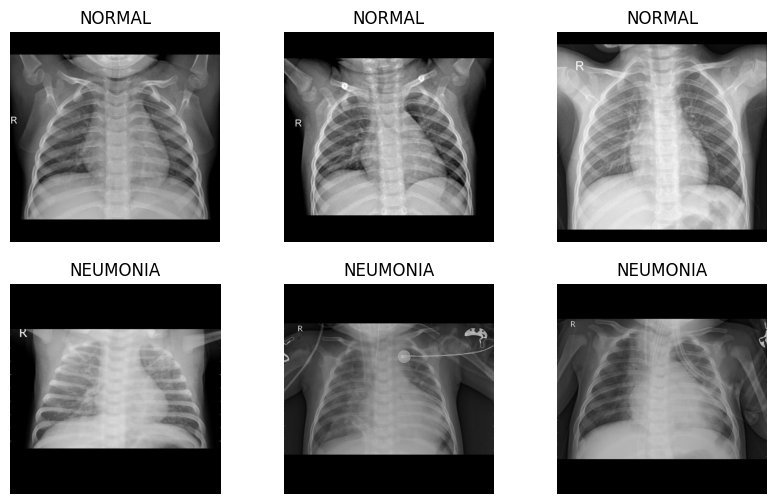


======= PROPIEDADES GLCM =======

Imagen: NORMAL2-IM-0649-0001.jpeg | Clase: NORMAL
Dist=1, Ang=0 | Contrast=26.7379, Correlation=0.9967, Energy=0.0539, Homogeneity=0.5667
Dist=1, Ang=0.79 | Contrast=121.2555, Correlation=0.9852, Energy=0.0491, Homogeneity=0.4998
Dist=1, Ang=1.57 | Contrast=100.5679, Correlation=0.9877, Energy=0.0501, Homogeneity=0.5618
Dist=1, Ang=2.36 | Contrast=124.4178, Correlation=0.9848, Energy=0.0492, Homogeneity=0.4981
Dist=3, Ang=0 | Contrast=129.4668, Correlation=0.9842, Energy=0.0515, Homogeneity=0.4412
Dist=3, Ang=0.79 | Contrast=271.5278, Correlation=0.9667, Energy=0.0493, Homogeneity=0.4354
Dist=3, Ang=1.57 | Contrast=340.8818, Correlation=0.9582, Energy=0.0483, Homogeneity=0.4438
Dist=3, Ang=2.36 | Contrast=275.8992, Correlation=0.9662, Energy=0.0492, Homogeneity=0.4333
Dist=5, Ang=0 | Contrast=208.6306, Correlation=0.9744, Energy=0.0500, Homogeneity=0.4021
Dist=5, Ang=0.79 | Contrast=543.8960, Correlation=0.9328, Energy=0.0453, Homogeneity=0.3766
Dist=

In [52]:
import os
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# 1. Funciones GLCM sin scikit-image (para Python 3.13)
# -----------------------------
def glcm_matrix(img, distance=1, angle=0, levels=256):
    rows, cols = img.shape
    glcm = np.zeros((levels, levels), dtype=np.float64)

    dx = int(round(np.cos(angle) * distance))
    dy = int(round(np.sin(angle) * distance))

    for i in range(rows):
        for j in range(cols):
            x = i + dy
            y = j + dx
            if 0 <= x < rows and 0 <= y < cols:
                glcm[img[i,j], img[x,y]] += 1

    glcm /= glcm.sum()
    return glcm


def glcm_props(glcm):
    i, j = np.indices(glcm.shape)

    contrast = np.sum(glcm * (i - j)**2)
    energy = np.sum(glcm**2)
    homogeneity = np.sum(glcm / (1 + np.abs(i - j)))

    μ_i = np.sum(i * glcm)
    μ_j = np.sum(j * glcm)
    σ_i = np.sqrt(np.sum((i - μ_i)**2 * glcm))
    σ_j = np.sqrt(np.sum((j - μ_j)**2 * glcm))

    if σ_i == 0 or σ_j == 0:
        correlation = 1
    else:
        correlation = np.sum(((i - μ_i) * (j - μ_j) * glcm) / (σ_i * σ_j))

    return contrast, correlation, energy, homogeneity


def compute_glcm_features(img, distances=[1,3,5],
                          angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):

    img = img.astype(np.uint8)
    results = []

    for d in distances:
        for a in angles:
            glcm = glcm_matrix(img, distance=d, angle=a, levels=256)
            props = glcm_props(glcm)

            results.append({
                "distance": d,
                "angle": a,
                "contrast": props[0],
                "correlation": props[1],
                "energy": props[2],
                "homogeneity": props[3]
            })

    return results

# -----------------------------
# 2. Seleccionar imágenes como tú lo hiciste
# -----------------------------
normal_images = os.listdir(train_normal)
neumonia_images = os.listdir(train_pneumonia)

random_normal_images = random.sample(normal_images, 3)
random_neumonia_images = random.sample(neumonia_images, 3)

selected_images = random_normal_images + random_neumonia_images

# -----------------------------
# 3. Mostrar 2x3 imágenes
# -----------------------------
plt.figure(figsize=(10, 6))

for idx, img_name in enumerate(selected_images):
    if idx < 3:
        path = os.path.join(train_normal, img_name)
        title = "NORMAL"
    else:
        path = os.path.join(train_pneumonia, img_name)
        title = "NEUMONIA"

    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    plt.subplot(2, 3, idx + 1)
    plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.axis("off")

plt.show()

# -----------------------------
# 4. Calcular GLCM de cada imagen seleccionada
# -----------------------------
print("\n======= PROPIEDADES GLCM =======")

for idx, img_name in enumerate(selected_images):

    if idx < 3:
        path = os.path.join(train_normal, img_name)
        clase = "NORMAL"
    else:
        path = os.path.join(train_pneumonia, img_name)
        clase = "NEUMONIA"

    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    features = compute_glcm_features(
        img,
        distances=[1, 3, 5],
        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]
    )

    print(f"\nImagen: {img_name} | Clase: {clase}")
    for f in features:
        print(f"Dist={f['distance']}, Ang={round(f['angle'],2)} | "
              f"Contrast={f['contrast']:.4f}, "
              f"Correlation={f['correlation']:.4f}, "
              f"Energy={f['energy']:.4f}, "
              f"Homogeneity={f['homogeneity']:.4f}")


## 🧩 **Construcción del vector de características final**
Siguiendo la estructura del notebook de tu compañero, combinamos todo en un único vector.

In [53]:
def build_feature_vector(img):
    features = compute_glcm_features(
        img,
        distances=[1, 3, 5],
        angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]
    )

    vector = []

    for f in features:
        vector.append(f['contrast'])
        vector.append(f['correlation'])
        vector.append(f['energy'])
        vector.append(f['homogeneity'])

    return np.array(vector)


In [54]:
feature_vectors = []
labels = []

for idx, img_name in enumerate(selected_images):

    if idx < 3:
        path = os.path.join(train_normal, img_name)
        clase = 0   # normal
    else:
        path = os.path.join(train_pneumonia, img_name)
        clase = 1   # neumonía

    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    vec = build_feature_vector(img)
    feature_vectors.append(vec)
    labels.append(clase)

feature_vectors = np.array(feature_vectors)
labels = np.array(labels)


In [55]:
print("Shape del vector:", feature_vectors.shape)
print(feature_vectors)
print(labels)



Shape del vector: (6, 48)
[[2.67379296e+01 9.96736120e-01 5.39201169e-02 5.66679993e-01
  1.21255518e+02 9.85170783e-01 4.91473261e-02 4.99847040e-01
  1.00567851e+02 9.87716793e-01 5.00531181e-02 5.61827163e-01
  1.24417806e+02 9.84784044e-01 4.91543425e-02 4.98084455e-01
  1.29466812e+02 9.84157488e-01 5.14596541e-02 4.41178638e-01
  2.71527805e+02 9.66687212e-01 4.92641423e-02 4.35407469e-01
  3.40881830e+02 9.58208019e-01 4.83217595e-02 4.43821434e-01
  2.75899223e+02 9.66150898e-01 4.92405551e-02 4.33318583e-01
  2.08630559e+02 9.74406468e-01 4.99559492e-02 4.02111094e-01
  5.43895991e+02 9.32837882e-01 4.52738801e-02 3.76569173e-01
  5.68903392e+02 9.29981959e-01 4.63689609e-02 4.01177981e-01
  5.45008428e+02 9.32700514e-01 4.53018233e-02 3.73097525e-01]
 [3.96252217e+01 9.96436094e-01 1.15402231e-01 5.65713817e-01
  1.34346935e+02 9.87908961e-01 1.13330657e-01 5.25620475e-01
  1.06024148e+02 9.90462901e-01 1.15131752e-01 5.68173398e-01
  1.43492756e+02 9.87085848e-01 1.13300023e